## EIT SECTION

Using the pyEIT library, we artificially create contacts (anomalies). We then obtain the voltage matrices generated by these anomalies.

In [6]:
pip install pyEIT

*   Creating a function generate a anomaly thanks to given anomlay center, radius and permitivity

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pyeit.eit.bp as bp
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward
from pyeit.mesh.wrapper import PyEITAnomaly_Circle

def generate_voltage_matrix(anomaly_center, anomaly_radius, anomaly_perm):
    """Function to generate voltage matrix with varying anomaly."""
    # 0. Build mesh
    n_el = 16  # Number of electrodes
    mesh_obj = mesh.create(n_el, h0=0.1)

    # 1. Problem setup
    anomaly = PyEITAnomaly_Circle(center=anomaly_center, r=anomaly_radius, perm=anomaly_perm)
    mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)

    # 2. FEM forward simulations
    protocol_obj = protocol.create(n_el, dist_exc=1, step_meas=1, parser_meas="std")
    fwd = EITForward(mesh_obj, protocol_obj)
    v0 = fwd.solve_eit()
    v1 = fwd.solve_eit(perm=mesh_new.perm)

    # 3. Naive inverse solver using back-projection
    eit = bp.BP(mesh_obj, protocol_obj)
    eit.setup(weight="none")
    ds = 192.0 * eit.solve(v1, v0, normalize=True)

    return ds, mesh_obj, mesh_new, mesh_obj.node, mesh_obj.element

In [8]:
# Example usage:
anomaly_center = [-0.2, 0.2]
anomaly_radius = 0.1
anomaly_perm = 10.0

voltage_matrix, mesh_obj, mesh_new, pts, tri = generate_voltage_matrix(anomaly_center, anomaly_radius, anomaly_perm)

voltagemat = generate_voltage_matrix([0.4,0.2], anomaly_radius, anomaly_perm)[0]


*   Creating a function to get the Conductivity distribution created by the anomay

In [76]:
def display_single_voltage_matrix(voltage_matrix, figsize=(8, 6)):
    """Display a single voltage matrix with original and reconstructed conductivity distributions."""
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    fig.subplots_adjust(wspace=0.4)



    # Plot reconstructed conductivity distribution
    ax1 = axes
    ax1.axis('equal')
    ax1.set_title("Conductivity Distribution")
    im1 = ax1.tripcolor(pts[:, 0], pts[:, 1], tri, voltage_matrix, shading="flat", cmap='inferno')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    plt.tight_layout()
    plt.show()

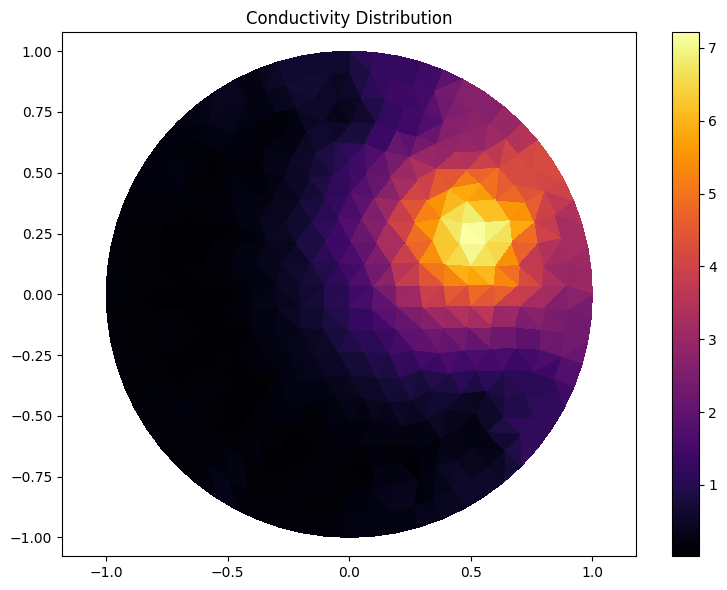

In [77]:
display_single_voltage_matrix(voltagemat)

# Dataset Creation :
Not to be executed unless you want to create an other that the "Dataset_EIT" provided

Creating a Dataset of voltage matrixes with randomly placed anomaly of fixed radius and permitivity

In [ ]:
import random

# Define fixed anomaly radius and permittivity
anomaly_radius = 0.1
anomaly_perm = 10.0

# Define the range for random anomaly centers
x_range = (-0.5, 0.5)
y_range = (-0.5, 0.5)

# Number of random samples
num_samples = 1000

# Create an empty list to store dataset entries
dataset = []

# Generate random anomaly centers and create dataset
for _ in range(num_samples):
    center = [random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1])]
    ds, mesh_obj, mesh_new, pts, tri = generate_voltage_matrix(center, anomaly_radius, anomaly_perm)
    dataset.append((center, anomaly_radius, anomaly_perm, ds, mesh_obj, mesh_new, pts, tri))

In [ ]:
print(dataset[999][5])

PyEITMesh(node=array([[-1.        ,  0.        ,  0.        ],
       [-0.92387953,  0.38268343,  0.        ],
       [-0.70710678,  0.70710678,  0.        ],
       ...,
       [-0.10184426,  0.99480035,  0.        ],
       [ 0.09824692,  0.99516209,  0.        ],
       [ 0.19690744,  0.98042209,  0.        ]]), element=array([[318, 336, 335],
       [155, 154, 134],
       [153, 152, 133],
       ...,
       [215, 196, 216],
       [196, 195, 175],
       [176, 196, 175]], dtype=int32), perm=array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 

*   Displaying the dataset's anomalies repartition

In [ ]:
anomaly_centers = np.array([entry[0] for entry in dataset])

x_coords = anomaly_center[:, 0]
y_coords = anomaly_center[:, 1]

# Plot the generated coordinates
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, s=5, color='blue', alpha=0.5)
plt.title('Coordinates within Square Grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.xlim(-0.55, 0.55)  # Adjust xlim and ylim for better visualization
plt.ylim(-0.55, 0.55)
plt.show()

#Dataset Exportation
Exporting the dataset to a .pkl file to preserve the format of variables in the pyeit type.  
Not to be executed unless you created a different dataset.

We use pickle to export our dataset while keeping the format of the eit elements

In [ ]:
import pickle


# Define the file path for saving the data
file_path = 'Dataset_EIT.pkl'

# Save the data to a Pickle file
with open(file_path, 'wb') as file:
    pickle.dump(dataset, file)

print("Data exported to", file_path)


#Dataset Importation

Import the dataset : "Dataset_EIT" and restoring it to it's original form

In [11]:
import pickle

# Define the file path for loading the dataset
file_path = 'Dataset_EIT.pkl'

# Load the dataset from the Pickle file
with open(file_path, 'rb') as file:
    loaded_dataset = pickle.load(file)

print("Dataset loaded successfully from", file_path)

reconstructed_dataset = []

for entry in loaded_dataset:
    center = entry[0]
    anomaly_radius = entry[1]
    anomaly_perm = entry[2]
    ds = entry[3]
    mesh_obj = entry[4]
    mesh_new = entry[5]
    pts = entry[6]
    tri = entry[7]

    # Append the reconstructed entry to the dataset
    reconstructed_dataset.append((center, anomaly_radius, anomaly_perm, ds, mesh_obj, mesh_new, pts, tri))

print("Dataset restored to its original form")


Dataset loaded successfully from Dataset_EIT.pkl
Dataset restored to its original form


In [12]:
reconstructed_dataset[3]

([0.10562118300538992, -0.4287248639787159],
 0.1,
 10.0,
 array([ 3.92764880e-01,  2.33190311e-01,  1.67961049e-01,  1.42816780e-01,
         1.39914324e-01,  1.55992380e-01,  1.97291669e-01,  2.85320628e-01,
         4.80698394e-01,  9.83247707e-01,  2.01167713e+00,  2.86026792e+00,
         4.17033417e+00,  3.11911477e+00,  1.55985385e+00,  7.77622910e-01,
         3.11911477e+00,  4.17033417e+00,  3.11911477e+00,  3.29263111e+00,
         3.11911477e+00,  4.17033417e+00,  4.46393935e+00,  4.17033417e+00,
         1.65935855e+00,  1.55985385e+00,  3.10922940e+00,  2.89441618e+00,
         3.53870237e+00,  4.66333854e+00,  4.46393935e+00,  4.17033417e+00,
         5.56833733e+00,  2.86026792e+00,  3.03806362e+00,  1.55985385e+00,
         1.55985385e+00,  1.65935855e+00,  1.55985385e+00,  3.38458897e+00,
         3.15663824e+00,  3.53870237e+00,  4.58003642e+00,  4.56000334e+00,
         5.29475431e+00,  2.86026792e+00,  3.07943140e+00,  2.86026792e+00,
         2.86026792e+00,  7.77

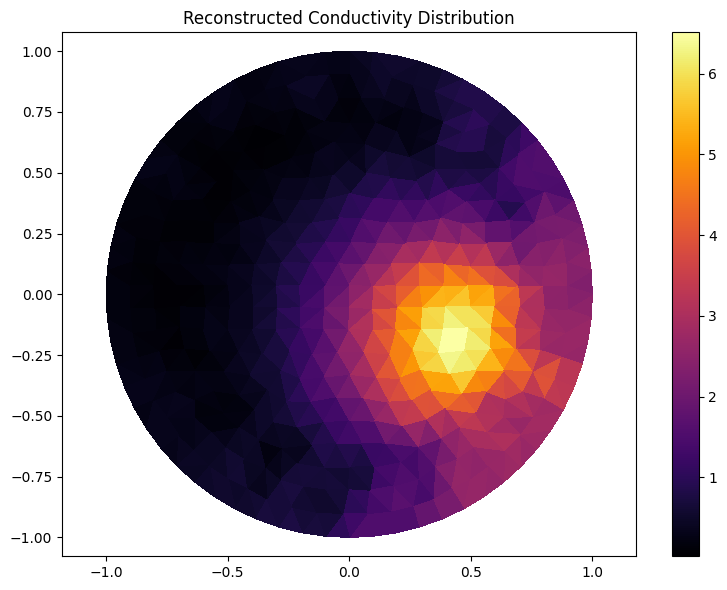

In [13]:
# Example usage:
# Displaying the first entry in the dataset
first_entry = reconstructed_dataset[8]
display_single_voltage_matrix(first_entry[3])


# Preprocessing of the Dataset

Here are a fue preprocessing step to make sure our data have the requiered form for an effective kohonen training

We flatten and normalize the voltage matrices so that they are in a suitable format for the Kohonen algorithm.

In [14]:
def flatten_voltage_matrices(dataset):
    """Flatten the voltage matrices in the dataset."""
    flattened_dataset = []
    for entry in dataset:
        # Extract the voltage matrix from the dataset entry
        ds = entry[3]/10
        # Flatten the voltage matrix and append to the flattened dataset
        flattened_dataset.append(ds.flatten())
        data = np.array(flattened_dataset)
    return data

In [15]:
# Example usage:
data = flatten_voltage_matrices(reconstructed_dataset)
print(data[1])  # Print the flattened voltage matrix of the first entry in the dataset

[0.05726956 0.05561452 0.05266316 0.04984574 0.04993078 0.05695769
 0.07215637 0.09042876 0.10395704 0.10585008 0.09641108 0.08989691
 0.08334376 0.07154834 0.06191051 0.05791517 0.07154834 0.08334376
 0.07154834 0.09105018 0.07154834 0.08334376 0.09471381 0.08334376
 0.08698447 0.06191051 0.05478114 0.05630629 0.05341356 0.09671242
 0.09471381 0.08334376 0.10565133 0.08989691 0.1114417  0.06191051
 0.06191051 0.08698447 0.06191051 0.06588721 0.06830534 0.05341356
 0.04844178 0.10264574 0.07494747 0.08989691 0.10910432 0.08989691
 0.08989691 0.05791517 0.07816081 0.046403   0.08677424 0.02990126
 0.03990541 0.05812138 0.06758691 0.05309674 0.05407628 0.05428574
 0.10910432 0.05418384 0.11098763 0.09641108 0.07429652 0.05791517
 0.07924138 0.0293873  0.05629014 0.05418076 0.06470892 0.10341822
 0.11086156 0.0923339  0.09547326 0.07046863 0.06424378 0.13220753
 0.09641108 0.11910287 0.05791517 0.08385947 0.04267312 0.03603541
 0.07212955 0.09229121 0.11039768 0.11439507 0.14946342 0.1371

*   Separating the dataset is training data and the according anomaly centers

In [45]:
from sklearn.model_selection import train_test_split

anomaly_centers = np.array([entry[0] for entry in reconstructed_dataset])

train_data = data
train_centers = anomaly_centers
print(len(train_data))

1000


*   Since our artificial skin was supposed to be a circle, we make sure our training data ar limited to a circle

In [46]:
# Circle parameters
circle_radius = 0.5
circle_center = np.array([0, 0])

# Calculate Euclidean distances from the origin (0, 0) to each center point
distances_from_origin = np.linalg.norm(train_centers - circle_center, axis=1)

# Filter indices based on distance criteria
valid_indices = distances_from_origin <= circle_radius

# Filtered train_centers and train_data based on valid_indices
filtered_train_centers = train_centers[valid_indices]
filtered_train_data = train_data[valid_indices]

In [47]:
train_data = filtered_train_data
train_centers = filtered_train_centers

*   Displaying the data

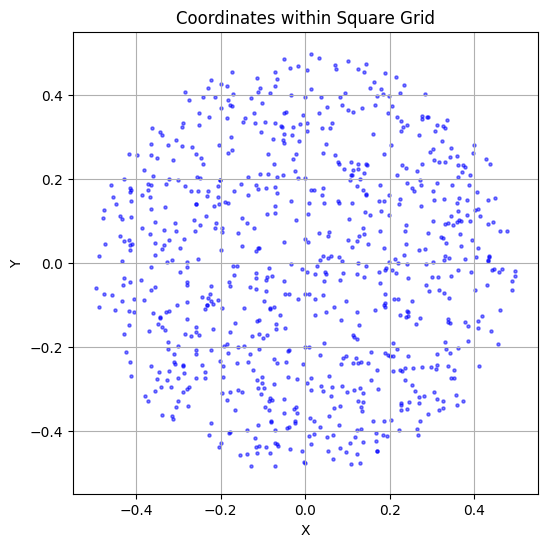

In [48]:
x_coords = train_centers[:, 0]
y_coords = train_centers[:, 1]

# Plot the generated coordinates
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, s=5, color='blue', alpha=0.5)
plt.title('Coordinates within Square Grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.xlim(-0.55, 0.55)  # Adjust xlim and ylim for better visualization
plt.ylim(-0.55, 0.55)
plt.show()

#Training

*   Initializing our SOM model with 16x16 neurons matrix
*   Training it with 10000 epochs
*   Getting the activated neurons : Best Matching Unit (bmu) and the reconstructed data thanks to the bmu and the weight

In [ ]:
pip install minisom

In [71]:
import numpy as np
from minisom import MiniSom
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have your training data stored in train_data

# Initialize and train the SOM
n_neurons = 16
m_neurons = 16
som = MiniSom(n_neurons, m_neurons, train_data.shape[1], sigma= 1, learning_rate=1,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.pca_weights_init(train_data)
som.train(train_data, 10000, verbose=True)  # random training

bmu_indices = np.array([som.winner(x) for x in train_data])
reconstructed_data = np.array([som._weights[bmu_idx[0], bmu_idx[1]] for bmu_idx in bmu_indices])


/usr/local/lib/python3.10/dist-packages/minisom.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.21815004297930832


*   Displaying the topographic error to see if our model keep the topology of our inputs

In [51]:
som.topographic_error(train_data[:850])

0.047979797979797977

*   We display the activated neurons and their density of activation

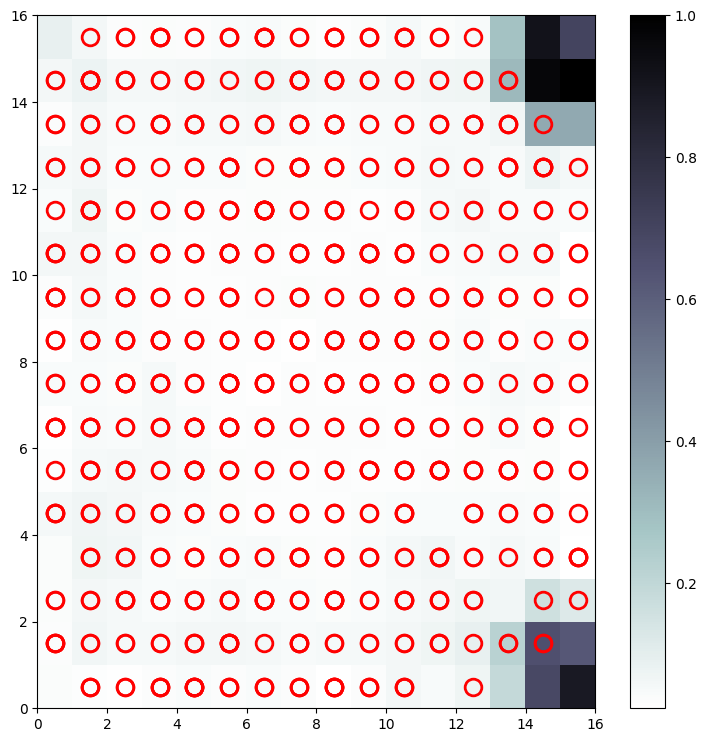

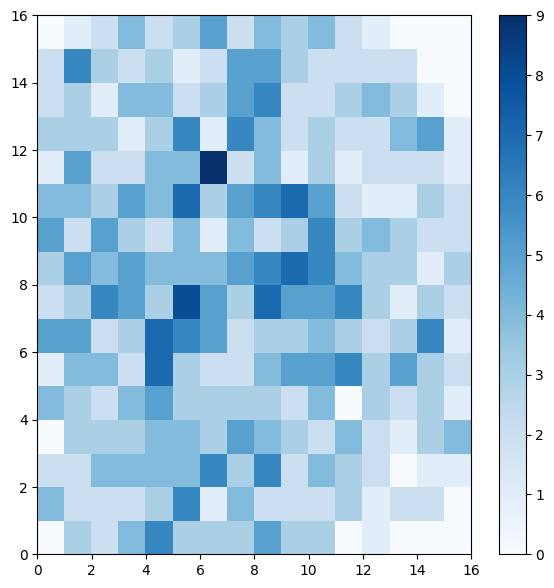

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # Plot the distance map as background
plt.colorbar()

# Plot the response for each pattern in the dataset
for entry in train_data:
    w = som.winner(entry)  # Get the winner neuron
    # Place a marker on the winning position for the sample entry
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None', markeredgecolor='r', markersize=12, markeredgewidth=2)
plt.show()



plt.figure(figsize=(7, 7))
frequencies = som.activation_response(train_data)
plt.pcolor(frequencies.T, cmap='Blues')
plt.colorbar()
plt.show()

*   Displaying the MSE between train data and reconstructed ones
*   Plotting both the train and reconstructed data to compare them

Mean Squared Error (MSE) between original and reconstructed data: 0.00017822244679116026


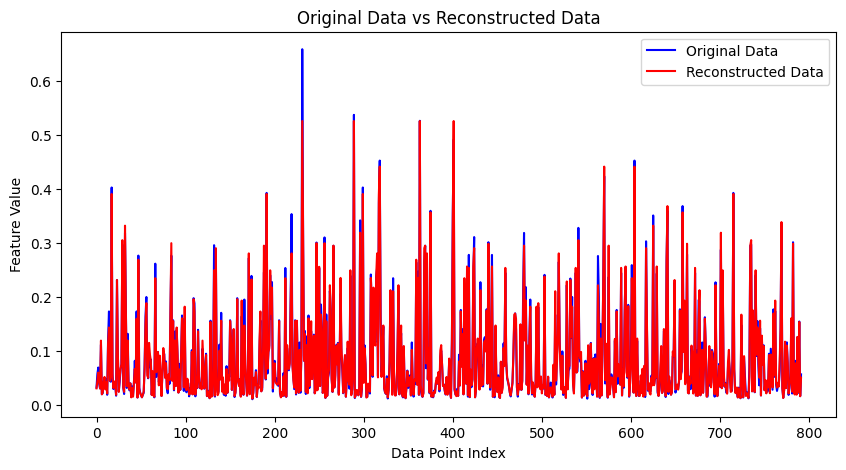

In [73]:
# Get the BMU for each data point after training
bmu_indices = np.array([som.winner(x) for x in train_data])

# Use the weight vectors to reconstruct the data
reconstructed_data = np.array([som._weights[bmu_idx[0], bmu_idx[1]] for bmu_idx in bmu_indices])

# Calculate Mean Squared Error (MSE) between original data and reconstructed data
mse_loss = mean_squared_error(train_data, reconstructed_data)
print("Mean Squared Error (MSE) between original and reconstructed data:", mse_loss)

# Plot the original data against the reconstructed data for visualization
plt.figure(figsize=(10, 5))
plt.plot(train_data[:, 0], label='Original Data', color='blue')
plt.plot(reconstructed_data[:, 0], label='Reconstructed Data', color='red')
plt.xlabel('Data Point Index')
plt.ylabel('Feature Value')
plt.title('Original Data vs Reconstructed Data')
plt.legend()
plt.show()

# Testing

This part aims to see if our kohonen is working in real conditions with data he has never seen

## Topology conversation



*   We create a function that aims to compare the original position of our anomalies and the resulting neurons activations



In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bmu_and_anomaly1(bmu_x, bmu_y, anomaly_position):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot BMU position
    ax0 = axes[0]
    ax0.set_title("BMU Position")
    for x, y in zip(bmu_x, bmu_y):
        ax0.scatter(x,
                    y,
                    s=50, c='r')
    ax0.set_xlim(-1, 16)  # Adjust X-axis limits for BMU scale
    ax0.set_ylim(-1, 16)  # Adjust Y-axis limits for BMU scale
    ax0.set_xlabel('X')
    ax0.set_ylabel('Y')
    ax0.grid(True)

    # Plot anomaly position
    ax1 = axes[1]
    ax1.set_title("Anomaly Position")
    for position in anomaly_position:
        ax1.scatter(position[0], position[1], color='b')
    ax1.set_xlim(-0.5, 0.5)  # Adjust X-axis limits for anomaly scale
    ax1.set_ylim(-0.5, 0.5)  # Adjust Y-axis limits for anomaly scale
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.grid(True)

    plt.tight_layout()
    plt.show()


*   Creating 2 function creating a square and a circle to see if our kohonen keep the topology


In [56]:
def generate_circle_points(num_points, radius):
    theta = np.linspace(0, 2*np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack((x, y))

def generate_square_points(side_length,num_points_per_side):
   # Define the vertices of the square
    vertices = np.array([
        [-0.4, -0.4],                   # Bottom-left corner
        [side_length, -0.4],         # Bottom-right corner
        [side_length, side_length],  # Top-right corner
        [-0.4, side_length]          # Top-left corner
    ])

    # Initialize an empty list to store the points
    square_points = []

    # Generate points along each side of the square
    for i in range(4):  # Iterate over each side (each pair of consecutive vertices)
        start_point = vertices[i]
        end_point = vertices[(i + 1) % 4]  # Wrap around to the first vertex after the last one

        # Generate evenly spaced points between the start and end vertices
        points_on_side = np.linspace(start_point, end_point, num_points_per_side + 1)
        square_points.extend(points_on_side[:-1])  # Exclude the endpoint of the last segment

    # Convert the list of points to a NumPy array
    square_points = np.array(square_points)

    return square_points

In [57]:
cercle = generate_circle_points(20,0.4)

In [39]:
side_length = 0.4
num_points_per_side = 5
square_points = generate_square_points(side_length, num_points_per_side)

*   Generating voltage matrixes with those centers

In [58]:
circle_data = []
for i in cercle:
    ds = generate_voltage_matrix(i, anomaly_radius, anomaly_perm)[0]
    circle_data.append(ds)

In [40]:
square_data = []
for i in square_points:
    ds = generate_voltage_matrix(i, anomaly_radius, anomaly_perm)[0]
    square_data.append(ds)

* Getting the winning neurons for each form

In [59]:
wcircle_x, wcircle_y = zip(*[som.winner(d) for d in circle_data])

In [61]:
wsquare_x, wsquare_y = zip(*[som.winner(d) for d in square_data])

*  Plotting the topology of the circle

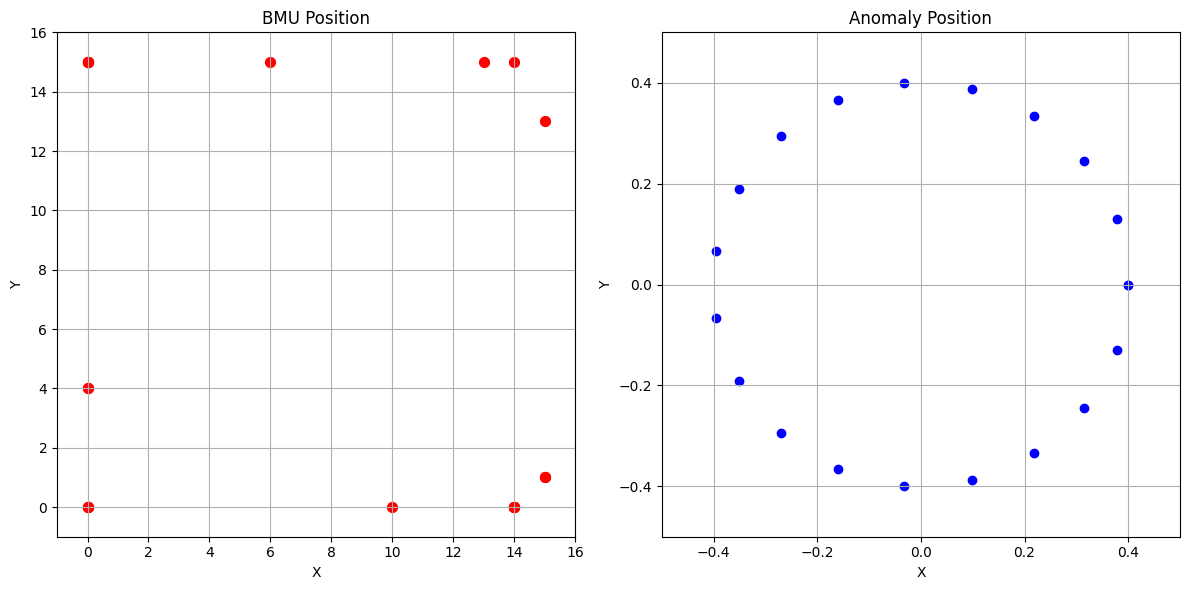

In [60]:
plot_bmu_and_anomaly1(wcircle_x, wcircle_y, cercle)

*   Plotting the square's one

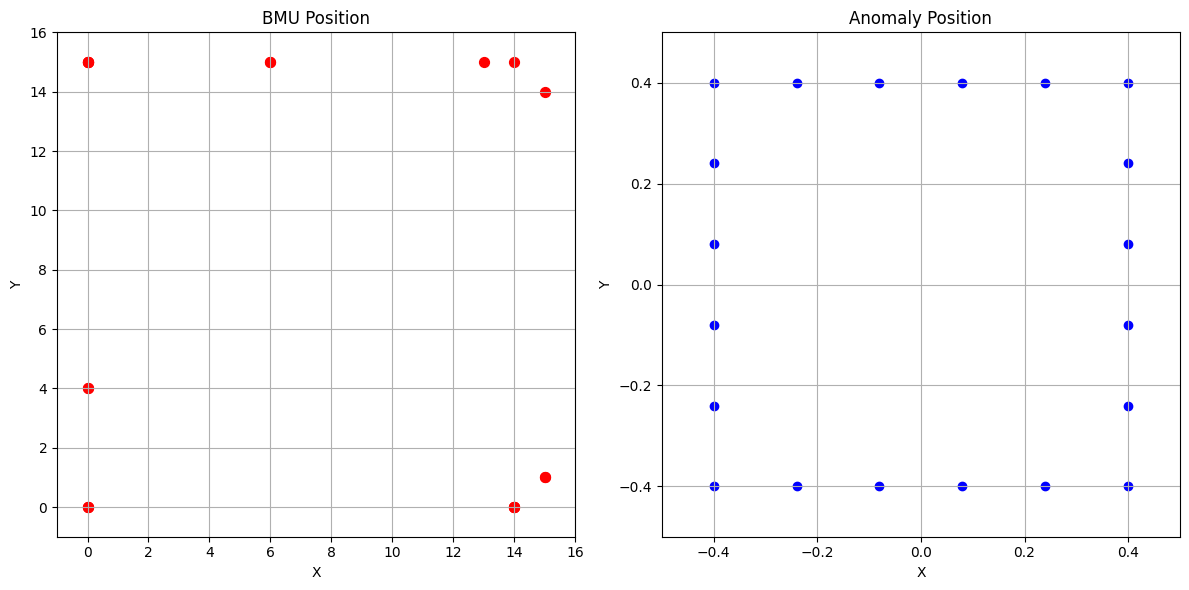

In [62]:
plot_bmu_and_anomaly1(wsquare_x, wsquare_y, square_points)

## Creating an anomaly thanks to cursors

Here we want to display the dynamic evolution of our prediction by simulating different contact position in real time

*   We create a function to display both the original conductivity distribution and the reconstructed one

In [65]:
def Compare_voltage_matrix(voltage_matrix_original, voltage_matrix_reconstructed, figsize=(8, 6)):
    """Display a single voltage matrix with original and reconstructed conductivity distributions."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.subplots_adjust(wspace=0.4)


    ax0 = axes[0]
    ax0.axis('equal')
    ax0.set_title("Original Conductivity Distribution")
    im0 = ax0.tripcolor(pts[:, 0], pts[:, 1], tri, voltage_matrix_original, shading="flat", cmap='inferno')
    fig.colorbar(im0, ax=ax0, orientation='vertical')
    # Plot reconstructed conductivity distribution
    ax1 = axes[1]
    ax1.axis('equal')
    ax1.set_title("Reconstructed Conductivity Distribution")
    im1 = ax1.tripcolor(pts[:, 0], pts[:, 1], tri, voltage_matrix_reconstructed, shading="flat", cmap='inferno')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    plt.tight_layout()
    plt.show()

  *   We then create a function that updates the graphs every time we move the cursors

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

def create_anomaly_with_input():
    # Define a function to handle the input and visualize the anomaly
    def handle_input(x, y):
        # Convert input to numpy array
        anomaly_center = np.array([x, y])

        # Define fixed anomaly radius and permittivity
        anomaly_radius = 0.1
        anomaly_perm = 10.0

        # Generate the voltage matrix for the anomaly
        anomaly_ds, mesh_obj, mesh_new, pts, tri = generate_voltage_matrix(anomaly_center, anomaly_radius, anomaly_perm)

        flattened_anomaly = anomaly_ds.flatten()

        # Find the best matching unit (BMU) for the anomaly
        bmu = som.winner(flattened_anomaly)
        reconstructed_data = som.get_weights()[bmu[0], bmu[1]]
        Compare_voltage_matrix(anomaly_ds,reconstructed_data)


    # Create interactive widgets for input
    x_input = widgets.FloatSlider(min=-0.5, max=0.5, step=0.01, value=-0.4, description='X:')
    y_input = widgets.FloatSlider(min=-0.5, max=0.5, step=0.01, value=-0.4, description='Y:')

    # Create interactive output for visualization
    interact(handle_input, x=x_input, y=y_input)

# Call the function to create an anomaly with interactive input and visualize the activated neuron
create_anomaly_with_input()


interactive(children=(FloatSlider(value=-0.4, description='X:', max=0.5, min=-0.5, step=0.01), FloatSlider(val…